In [2637]:
#Testing
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import math
import ruptures as rpt
import warnings
import holidays
from hijri_converter import convert
from datetime import date,datetime, timedelta
from prophet.diagnostics import performance_metrics, cross_validation
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

warnings.filterwarnings("ignore")

## Parameters

In [2638]:

# growth = 'linear' or 'logistic' or None or flat
growth=None # if this is none then growth will be determined by the user else it will be determined by our method if determineGrowth is true
determineGrowth=True # if this is true then growth will be determined by our method else it will be determined by the user
mcmc_samples=0 #300


#changepoints passed as param from PELT Algo
changepoint_prior_scale=0.10

#create an empty dataframe with ds an y column
customholidays_df = pd.DataFrame({'ds': [], 'holiday': []})
holidays_prior_scale=0.25

#seasonality_mode='multiplicative' or 'additive'
seasonality_mode='multiplicative'

yearly_seasonality=False # default one is 20 
weekly_seasonality=False
daily_seasonality=False

#High, Medium, Low which is used to determine the penalty value for the PELT algo which is used for changepoint detection
PenaltySensitivity ="High" #High, Medium, Low

# l1 linear 1 
# l2 linear 2 whisch is faster than l1
# rbf radial basis function
pltModelType = "l2"  # "l2", "rbf"

country_name='SA'

# interval_width: Sets the width of the uncertainty intervals provided in the forecast.
# A larger `interval_width` (e.g., 0.95) provides wider intervals, reflecting increased uncertainty.
# The default value is 0.8, corresponding to 80% intervals. Adjusting this parameter is useful for 
# quantifying the forecast uncertainty. A key aspect of this uncertainty measurement is its relationship 
# with the flexibility of the rate change (controlled by `changepoint_prior_scale`). Increasing the 
# `changepoint_prior_scale` will lead to wider uncertainty intervals because a model that is more 
# flexible in fitting rate changes to historical data anticipates more potential changes
interval_width=0.95 # Uncertainty in the trend


monthly_season='monthly'
monthly_season_period=30.5
monthly_season_fourier_order=10


ramadan_season='Monthly_Ramadan_season'
ramadan_period = 30
ramadan_fourier_order=10

#Weekend

weekend_days = [4]  #4 is Friday:  0-6:Mon-Sun

In [2639]:
# Load and prepare the data for Prophet
df = pd.read_csv('/home/ajaz/DemandForecasting/Data/data.csv')
data = df.rename(columns={'TransactionDate': 'ds', 'GroupCostPrice': 'y'})
data = data[['ds', 'y']]
data['ds']=pd.to_datetime(data['ds'])

# covid starting date
covid_start_date = '2020-03-02'
covid_end_date = '2020-06-21'

# filter the data frame before covid

data = data[data['ds'].dt.year ==2023]

#Get the first date of the data
start_date = pd.to_datetime( data['ds'].iloc[0])
#Get the last date of the data
end_date = pd.to_datetime( data['ds'].iloc[-1])

first_30Days = data.iloc[0:30]

#data.head(2)

### Parameter  Growth  

The growth was determined by our method
growth type is linear with window size 36


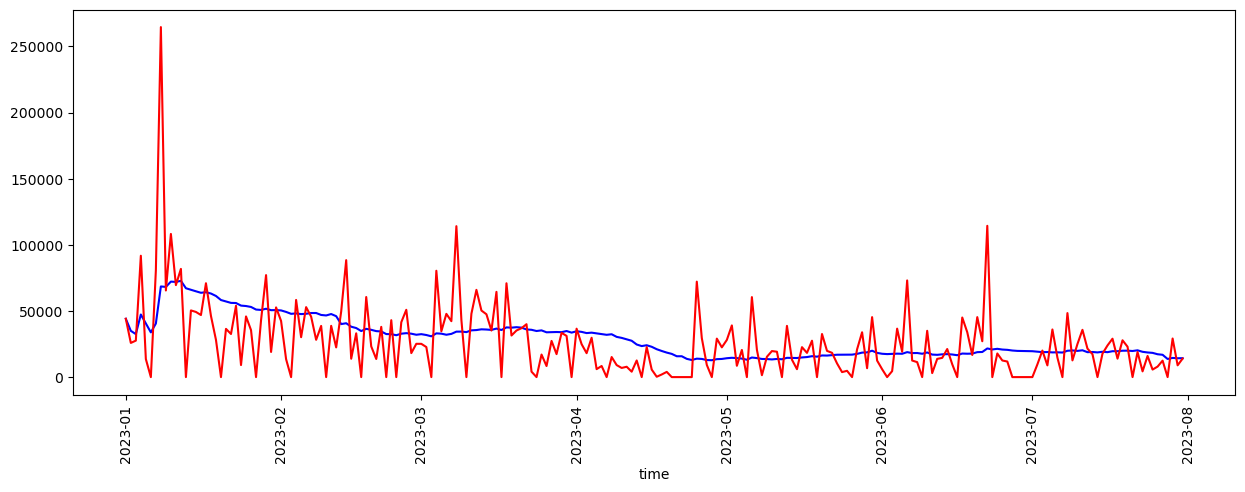

In [2640]:
# Function to decide whether data['y'] is logistic or linear
def get_smooth_data(df, date_column, value_column, window_size=30):
    """
    Smooths the data in the value_column using a rolling mean.

    Parameters:
    df (DataFrame): The input DataFrame with a date and a value column.
    date_column (str): The name of the column containing date information.
    value_column (str): The name of the column containing the data to smooth.
    window_size (int): The size of the rolling window to use for smoothing.

    Returns:
    DataFrame: A new DataFrame with an additional column 'smoothed_value'.
    """
    
    df_copy = df.copy()

    # Ensure the date column is in datetime format
    df_copy[date_column] = pd.to_datetime(df_copy[date_column])
    
    # Set the date column as the index for rolling
    df_copy.set_index(date_column, inplace=True)
    
    # Calculate the rolling mean
    df_copy[value_column] = df_copy[value_column].rolling(window=window_size, min_periods=1).mean()
    
    # Reset the index to return to the original format
    df_copy.reset_index(inplace=True)
    
    return df_copy


def logistic_function(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))

# Function to detect trend type by passing the dataframe, date column and value column names
def detect_trend(df, date_column, value_column):
    df['date_ordinal'] = pd.to_datetime(df[date_column]).apply(lambda date: date.toordinal())

    # Linear Fit
    linear_model = LinearRegression()
    linear_model.fit(df[['date_ordinal']], df[value_column])
    linear_r_squared = linear_model.score(df[['date_ordinal']], df[value_column])
    #print(f"Linear R-squared: {linear_r_squared}")

    if linear_r_squared > 0.70:  # Adjusted threshold
        return 'linear'
    
    # Logistic Fit
    try:
        popt, _ = curve_fit(logistic_function, df['date_ordinal'], df[value_column], maxfev=10000)
        logistic_r_squared = 1 - np.var(np.array(df[value_column]) - logistic_function(df['date_ordinal'], *popt)) / np.var(df[value_column])
        #print(f"Logistic R-squared: {logistic_r_squared}")

        if logistic_r_squared > 0.70:  # Adjusted threshold
            return 'logistic'
    except RuntimeError as e:
        print(f"Error in logistic fit: {e}")

    # Flat Trend
    std_dev = df[value_column].std()
    mean_val = df[value_column].mean()
    #print(f"Standard Deviation: {std_dev}, Mean: {mean_val}")

    if std_dev < (mean_val * 0.3):  # Adjusted threshold
        return 'flat'

    return 'Unknown'


# loop throgh number from 30 to 100 and find the best window size
#window_size=30
def get_growth_by_smoothing_data(data):
    '''
    This function will loop through the window size from 1 to len(data) and find the best window size
    the return value will be growth type and the smoothed data and the window size
    '''
    max_window_size=int(len(data) )
    for window_size in range(1,max_window_size):
        smooth_df=get_smooth_data(data,'ds','y',window_size=window_size)
        newGroth= detect_trend(smooth_df,'ds','y')
        if newGroth == 'Unknown':
            continue
        else:
            return newGroth, smooth_df, window_size
    return 'Unknown', smooth_df, window_size


# if the user passed determineGrowth as true then we will determine the growth type by our method
# and if didn't pass true then we will check if the user passed growth type or not

# Detect growth pattern
if determineGrowth == True:
    growth , smooth_df , window_size= get_growth_by_smoothing_data(data)
    print ("The growth was determined by our method")
    print('growth type is ' + growth + ' with window size ' + str(window_size))
    plt.plot(smooth_df['ds'], smooth_df['y'], linestyle = 'solid',color='blue')
else:
    if growth is None:
        # throw exception indicates that we need to pass growth type or determineGrowth should be true
        raise Exception("You should pass growth type one of these values ( linear , logistic or flat) or determineGrowth should be true" )
    else:
        print ("The growth was determined by the user")
        print( 'growth type is ' + growth )


# if the growth type is not flat or logistic or linear then we will throw exception
if growth not in ['flat','logistic','linear']:
    raise Exception("growth type should be one of these values ( linear , logistic or flat)" )


plt.plot(data['ds'], data['y'], linestyle = 'solid',color='red')


# a line plot like a trend over the time monthly
plt.xticks(rotation=90)
plt.xlabel('time')
fig = plt.gcf()
fig.set_size_inches(15, 5)


### Parameter 2: Change points PELT Algo

In [2641]:
def calculate_penalty(data, sensitivity, cal=[6, 3, 1.5]):
    if sensitivity == "Low":
        return cal[0] * math.log(len(data))
    elif sensitivity == "Medium":
        return cal[1] * math.log(len(data))
    elif sensitivity == "High":
        return cal[2] * math.log(len(data))

             ds           y
1826 2023-01-01   44090.010
1827 2023-01-02   25835.140
1828 2023-01-03   27574.320
1829 2023-01-04   91743.380
1830 2023-01-05   13638.970
1831 2023-01-06       0.000
1832 2023-01-07   80711.040
1833 2023-01-08  264583.100
1834 2023-01-09   65480.200
1835 2023-01-10  108217.400
1836 2023-01-11   69528.810
1837 2023-01-12   81814.210
1838 2023-01-13       0.000
1839 2023-01-14   50406.580
1840 2023-01-15   49255.510
1841 2023-01-16   46918.840
1842 2023-01-17   70947.810
1843 2023-01-18   46234.400
1844 2023-01-19   28143.970
1845 2023-01-20       0.000
1846 2023-01-21   36458.150
1847 2023-01-22   32579.610
1848 2023-01-23   53917.220
1849 2023-01-24    9106.529
1850 2023-01-25   45866.230
1851 2023-01-26   35497.140
1852 2023-01-27       0.000
1853 2023-01-28   42961.990
1854 2023-01-29   77098.080
1855 2023-01-30   19010.150


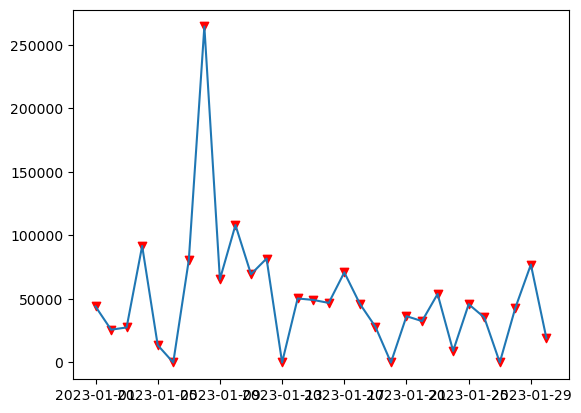

In [2642]:
peltdata = data['y'].values
# You can choose between "l1" and "l2" cost functions


algo = rpt.Pelt(model=pltModelType, min_size=1, jump=1).fit(peltdata)
penalty= calculate_penalty(peltdata, PenaltySensitivity)
result = algo.predict(pen=3)

changepointDates=[]
for index in result:
    a=data.iloc[index-1]['ds']
    changepointDates.append(a)

changepointDates=pd.DataFrame(changepointDates, columns=['ds'])
changepointDates['ds'] = pd.to_datetime(changepointDates['ds'])

changepoints=changepointDates['ds']
daysInChangepoints=first_30Days.loc[first_30Days['ds'].isin(changepoints)]

plt.plot(first_30Days['ds'],first_30Days['y'] )
plt.scatter(daysInChangepoints['ds'],daysInChangepoints['y'], marker='v', color='r')

print (daysInChangepoints)
#holidays=holidays
#changepointDates.head(2)

# Outlier

In [2643]:
# Assuming you have calculated Q1, Q3, IQR, lower_bound, and upper_bound
# as per the previous snippet
Q1 = data['y'].quantile(0.25)
Q3 = data['y'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

soutliers = data[((data['y'] < lower_bound) | (data['y'] > upper_bound))]

# Identifying outliers
outliers = data[((data['y'] < lower_bound) | (data['y'] > upper_bound))]

# Replace outlier values with the mean
data.loc[outliers.index, 'y'] = data['y'].mean()

# Optional: Print the updated DataFrame
#data.head(2)

## Ramadan Holidays

In [2644]:
def generate_ramadan_dates_df(start_year, end_year):
    ramadan_dates = []

    for year in range(start_year, end_year + 1):
        # The Umm al-Qura calendar uses Hijri dates for Islamic months
        hijri_year_start = convert.Gregorian(year, 1, 1).to_hijri()
        hijri_year_end = convert.Gregorian(year, 12, 30).to_hijri()

        for day in range(1, 30):  # Assuming Ramadan lasts for 29 or 30 days
            # Find the date of Ramadan in the Hijri calendar
            ramadan_date = convert.Hijri(hijri_year_start.year, 9, day).to_gregorian()

            # Append the date to the list
            ramadan_dates.append(ramadan_date)

    # Create a DataFrame with a column named 'ramadan_dates'
    ramadan_df = pd.DataFrame({'ds': ramadan_dates})
    return ramadan_df

In [2645]:
start_year = start_date.year
end_year = end_date.year
ramadan_df = generate_ramadan_dates_df(start_year, end_year)

## Weekend

In [2646]:
def generate_weekends(start_date, end_date, weekend_days):
    '''
    This function will generate weekends dataframe with ds and holiday columns
    Parameters : 
    start_date : start date of the data of type datetime
    end_date : end date of the data of type datetime
    weekend_days : list of weekend days ex: [4] for Friday
    return : weekends dataframe with ds and holiday columns
    '''
    weekends = []

    current_date = start_date

    while current_date <= end_date:
        # Check if the current date is a weekend
        if current_date.weekday() in weekend_days:
            weekends.append(current_date)
        current_date += timedelta(days=1)

    # Create a DataFrame with day names and dates
    weekend_df = {'ds': weekends,
                  'holiday': [day.strftime('%A') for day in weekends]}


    df_weekends = pd.DataFrame(weekend_df)
    return df_weekends

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


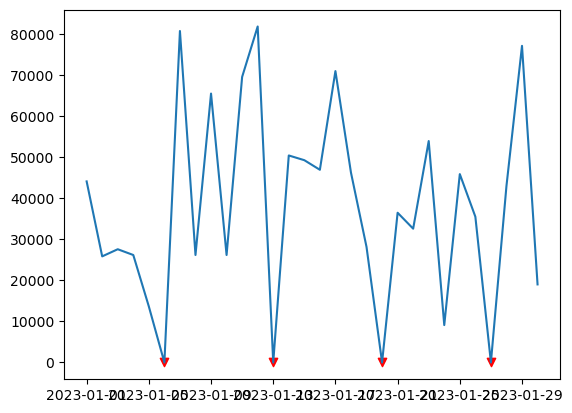

In [2647]:
print(type(start_date))
df_weekends = generate_weekends(start_date, end_date, weekend_days)
data['is_weekend'] = data['ds'].isin(df_weekends['ds']).astype(int)
data['is_weekday'] = (data['is_weekend'] == 0).astype(int)

first_30Days['is_weekend'] = first_30Days['ds'].isin(df_weekends['ds']).astype(int)

onlyWeekends= first_30Days[data['is_weekend']==1]

plt.plot(first_30Days['ds'],first_30Days['y'])
plt.scatter(onlyWeekends['ds'],onlyWeekends['y'], marker='v', color='r')


## Adding Extra Columns To dataframe

In [2648]:
# Create a binary indicator for Ramadan

# Define a percentile value (e.g., 99th percentile)
percentile_value = 99

# Calculate the specified percentile for the cap
cap = (np.percentile(data['y'], percentile_value)) * 1.5

# Define a lower percentile value (e.g., 5th percentile) for the floor
percentile_floor = 5

# Calculate the specified percentile for the floor
floor = np.percentile(data['y'], percentile_floor)

data['is_ramadan'] = data['ds'].isin(ramadan_df['ds']).astype(int)
prophet_data= data


#print (prophet_data[prophet_data['y'] == 0])

""" prophet_data['cap']=cap
prophet_data['floor']=floor """

" prophet_data['cap']=cap\nprophet_data['floor']=floor "

# Training

### Fitting the Model

In [2649]:
prophetModel = Prophet( growth=growth  
                #,mcmc_samples=mcmc_samples
               #,holidays= customholidays_df #if customholidays_df.empty else None
                ,changepoints=changepoints   
                ,holidays_prior_scale=holidays_prior_scale
                ,changepoint_prior_scale=changepoint_prior_scale
                ,seasonality_mode=seasonality_mode
                ,yearly_seasonality=yearly_seasonality
                ,weekly_seasonality=weekly_seasonality
                ,daily_seasonality=daily_seasonality
                ,interval_width=interval_width
                )
prophetModel.add_country_holidays(country_name=country_name)

weekendDaysCount= len(weekend_days)
workingDaysCount= 7 - weekendDaysCount

prophetModel.add_seasonality(
                 name='Weekends'
                ,period=weekendDaysCount 
                ,fourier_order=1     
                ,condition_name='is_weekend') 

prophetModel.add_seasonality(
                 name='WorkingDays'
                ,period=workingDaysCount
                ,fourier_order=3  
                #,mode='additive'
                ,condition_name='is_weekday'
                    ) 

""" 
prophetModel.add_seasonality(
                 name='weekday'
                ,period=6  
                ,fourier_order=10      
                ,condition_name='is_weekday')  """

""" prophetModel.add_seasonality(
                 name=ramadan_season
                ,period=ramadan_period  
                ,fourier_order=ramadan_fourier_order      
                ,condition_name='is_ramadan'
                ) """

prophetModel.add_seasonality(
                 name="Custom Month"
                ,period=monthly_season_period  
                ,fourier_order=monthly_season_fourier_order      
                )

metric=prophetModel.fit(prophet_data)


from prophet.diagnostics import cross_validation
df_cv = cross_validation(prophetModel, initial='180 days', period='30 days', horizon = '30 days')
df_cv


16:40:49 - cmdstanpy - INFO - Chain [1] start processing
16:40:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

16:40:49 - cmdstanpy - INFO - Chain [1] start processing
16:40:49 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2023-07-02,10792.723299,-20151.091392,38993.628801,9594.452,2023-07-01
1,2023-07-03,10639.847775,-20317.132306,41688.701423,20059.350,2023-07-01
2,2023-07-04,13547.638586,-14701.575987,43242.484248,8858.366,2023-07-01
3,2023-07-05,10991.813181,-18917.368682,38711.414044,35988.920,2023-07-01
4,2023-07-06,15623.795714,-12774.803669,45609.561219,14757.880,2023-07-01
5,2023-07-07,-419.135470,-29790.907022,30921.237859,0.000,2023-07-01
6,2023-07-08,10788.778268,-21196.491060,40194.550295,48384.640,2023-07-01
7,2023-07-09,11374.105611,-18713.513570,40920.998929,12623.370,2023-07-01
8,2023-07-10,14088.773084,-18490.579941,44171.372149,25003.520,2023-07-01
9,2023-07-11,10339.404415,-19097.992906,41372.673188,35734.490,2023-07-01


# Generate future dates

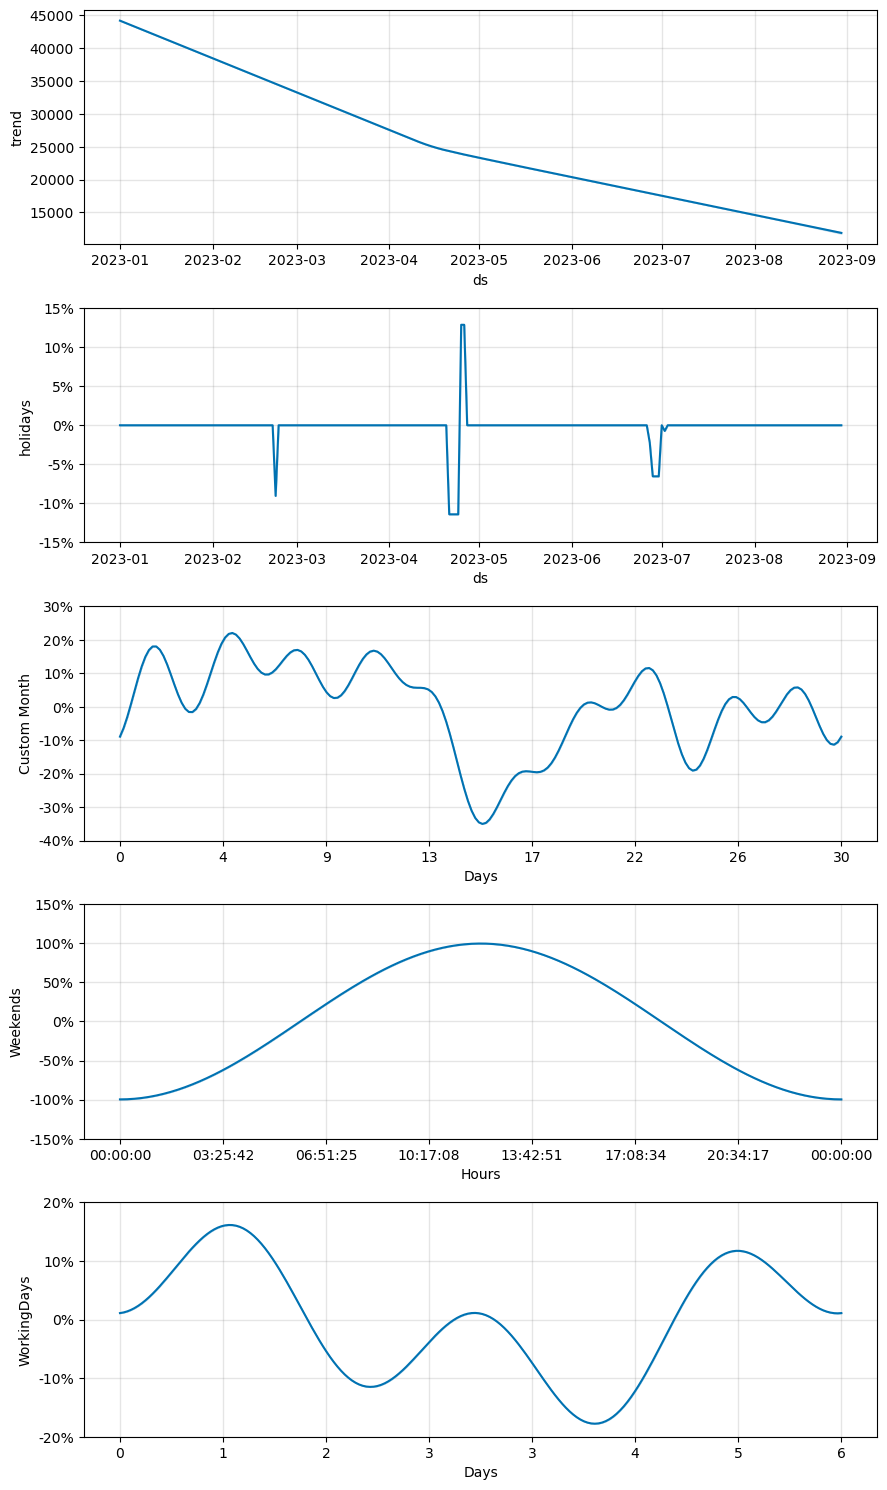

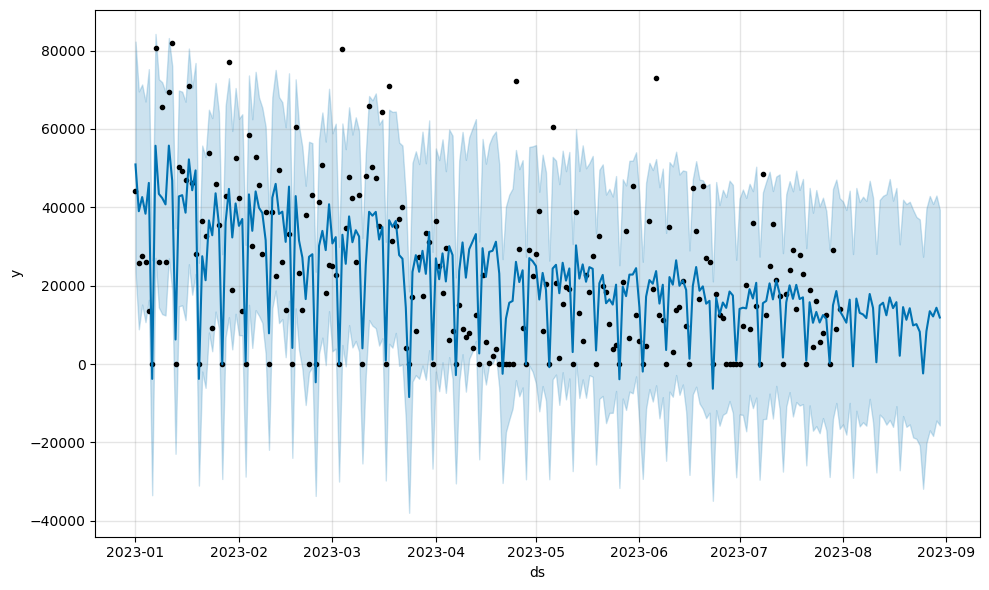

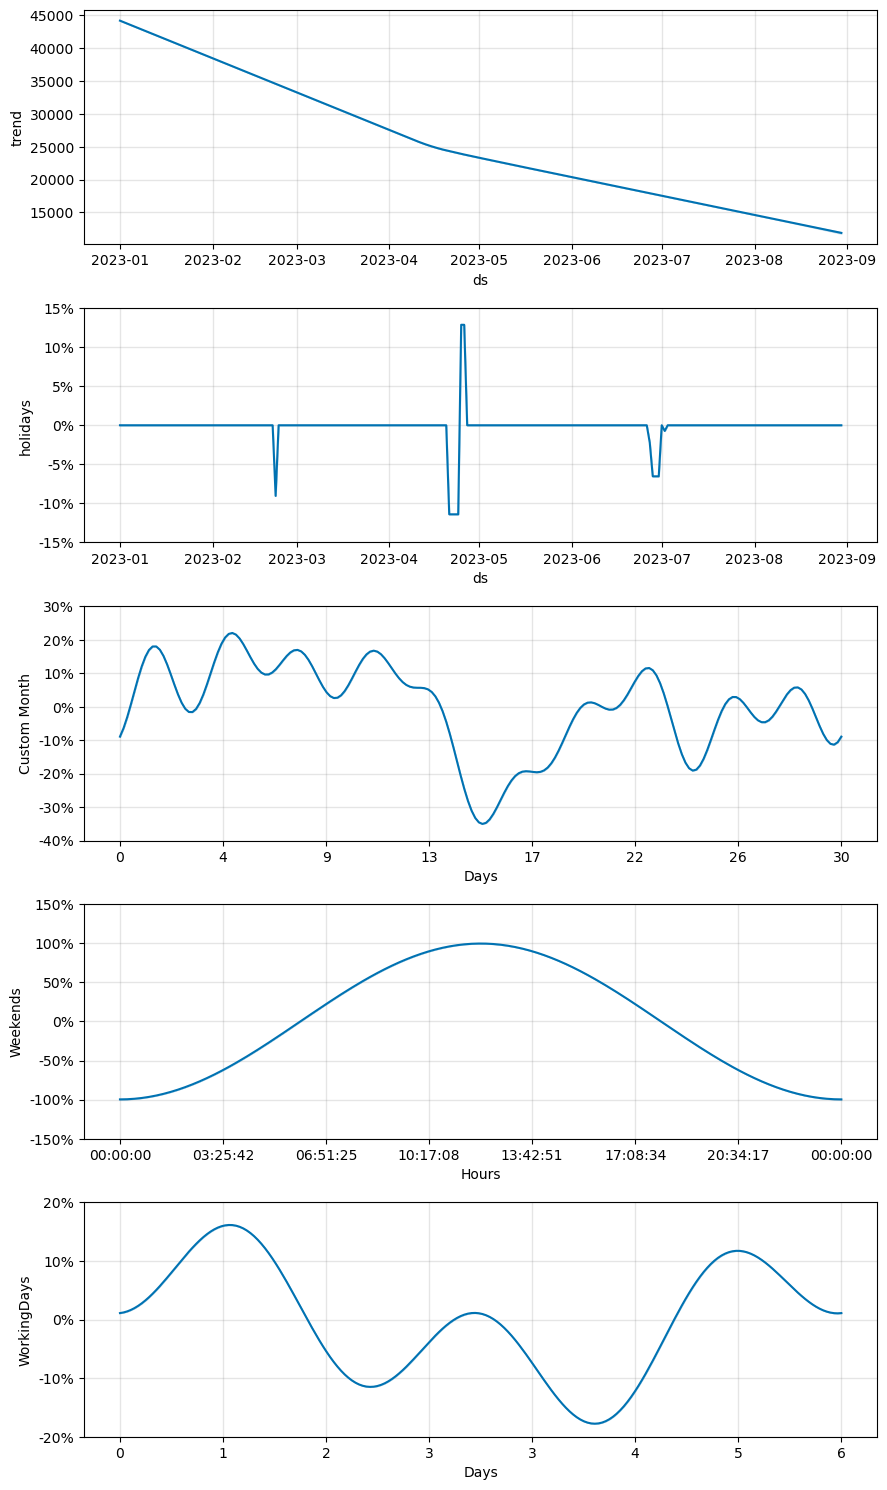

In [2650]:
### Generate future dates

future_df = prophetModel.make_future_dataframe(periods=30)
firstdate=future_df['ds'].iloc[0]
lastdate=future_df['ds'].iloc[-1]
future_weekends = generate_weekends(firstdate, lastdate, weekend_days)

future_df['is_ramadan'] = future_df['ds'].isin(ramadan_df['ds']).astype(int)
#future_df['cap'] = cap
#future_df['floor'] = floor

# Add the 'holidays' column to the future DataFrame
#future_df['holidays'] = 0
#future_df.loc[future_df['ds'].isin(df_weekends['ds']), 'holidays'] = 1



future_df['is_weekend'] = future_df['ds'].isin(future_weekends['ds']).astype(int)
future_df['is_weekday'] = (future_df['is_weekend'] == 0).astype(int)


### Generate predictions
forecast = prophetModel.predict(future_df)

prophetModel.plot(forecast)
prophetModel.plot_components(forecast)


#print('Sucessfully Exported')

In [2651]:
#future_df
#future_df.head(2)

In [2652]:
#fig = model.plot(model.predict(future_df)

## Cross Validation

In [2653]:
#3df_cv = cross_validation(model, initial='730 days', period='180 days', horizon = '30 days')
#df_p = performance_metrics(df_cv)
#df_p.head(2)




In [2654]:
#df_p = performance_metrics(df_cv)
#Mean MAPE across all horizons
#overall_mape = np.mean(df_p['smape'])
# Median MAPE (more robust to outliers)
#overall_mape_median = np.median(df_p['smape'])
#MAPEresult = overall_mape_median

# Comparision of ACtual And predicted Data

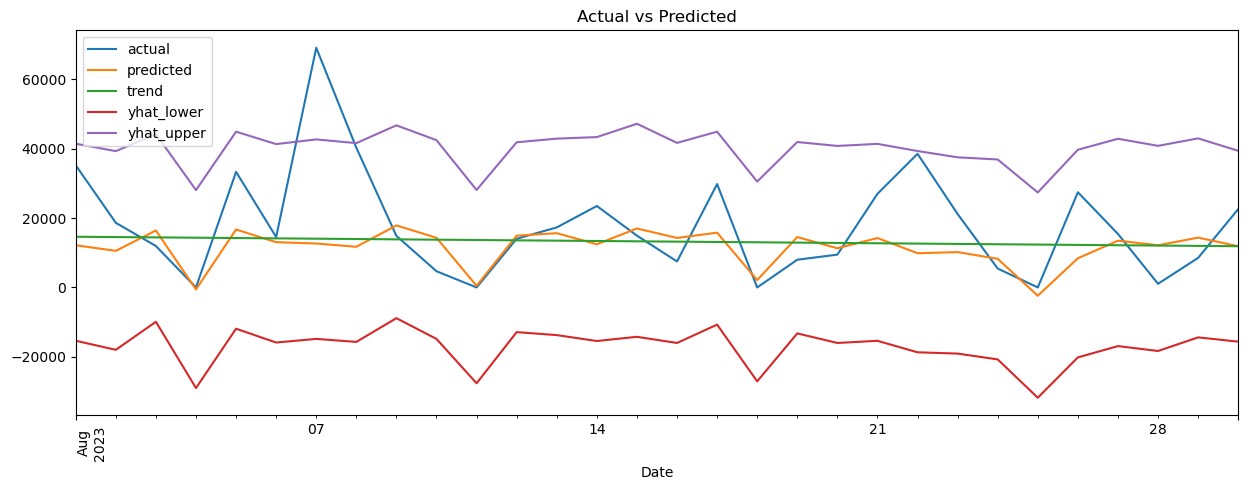

In [2655]:
#Create comment for the following code
### Analyze and visualize results

#forecast.to_csv('/home/ajaz/DemandForecasting/Data/Output/forecast.csv')
 

actualdata = pd.read_csv('/home/ajaz/DemandForecasting/Data/actualdata.csv')
actualdata = actualdata.rename(columns={'TransactionDate': 'ds', 'GroupCostPrice': 'actual'})
actualdata['ds']=pd.to_datetime(actualdata['ds'])


#predicteddata =forecast[['ds', 'yhat']].tail(30)
forecast = forecast.rename(columns={'ds': 'ds', 'yhat': 'predicted'})
forecast['ds']=pd.to_datetime(forecast['ds'])


finaldata = pd.merge(actualdata,forecast.tail(30),on='ds')



finaldata.plot(x='ds', y=['actual', 'predicted','trend','yhat_lower','yhat_upper'], kind='line', title='Actual vs Predicted')
#show the day name x axis
plt.xticks(rotation=90)
plt.xlabel('Date')
fig = plt.gcf()
fig.set_size_inches(15, 5)

# print the rows with negative values 



#finaldata.to_csv('/home/ajaz/DemandForecasting/Data/final.csv')

In [2656]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Arafat Day* (*estimated),Arafat Day* (*estimated)_lower,Arafat Day* (*estimated)_upper,Custom Month,...,holidays,holidays_lower,holidays_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,additive_terms,additive_terms_lower,additive_terms_upper,predicted
0,2023-01-01,44159.547104,23671.781258,82284.832907,44159.547104,44159.547104,0.0,0.0,0.0,-0.004473,...,0.0,0.0,0.0,0.153531,0.153531,0.153531,0.0,0.0,0.0,50939.398557
1,2023-01-02,43974.884290,8872.508929,69582.742772,43974.884290,43974.884290,0.0,0.0,0.0,-0.001295,...,0.0,0.0,0.0,-0.113011,-0.113011,-0.113011,0.0,0.0,0.0,39005.258930
2,2023-01-03,43790.221474,15185.814572,71340.803990,43790.221474,43790.221474,0.0,0.0,0.0,-0.036910,...,0.0,0.0,0.0,-0.026688,-0.026688,-0.026688,0.0,0.0,0.0,42621.544726
3,2023-01-04,43605.535344,10703.894780,66997.120743,43605.535344,43605.535344,0.0,0.0,0.0,0.056391,...,0.0,0.0,0.0,-0.120027,-0.120027,-0.120027,0.0,0.0,0.0,38371.700716
4,2023-01-05,43420.849191,16392.874331,75255.128257,43420.849191,43420.849191,0.0,0.0,0.0,-0.044173,...,0.0,0.0,0.0,0.064678,0.064678,0.064678,0.0,0.0,0.0,46229.201611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,2023-08-26,12275.498108,-20176.665881,39725.698047,12181.529204,12371.285347,0.0,0.0,0.0,-0.138164,...,0.0,0.0,0.0,-0.314582,-0.314582,-0.314582,0.0,0.0,0.0,8413.844515
238,2023-08-27,12181.295843,-16915.427370,42895.090350,12080.904986,12281.873804,0.0,0.0,0.0,-0.001040,...,0.0,0.0,0.0,0.107810,0.107810,0.107810,0.0,0.0,0.0,13494.561479
239,2023-08-28,12087.093579,-18327.680197,40850.634413,11981.067278,12192.168538,0.0,0.0,0.0,-0.004986,...,0.0,0.0,0.0,0.006071,0.006071,0.006071,0.0,0.0,0.0,12160.472053
240,2023-08-29,11992.891314,-14398.466983,43004.338605,11881.331234,12102.940350,0.0,0.0,0.0,0.040952,...,0.0,0.0,0.0,0.198955,0.198955,0.198955,0.0,0.0,0.0,14378.940782
